### Names
Ragger Jonkers (10542604)<br>
Joeri Sleegers (10631186)<br>
Eelco van der Wel (10670033)

### Theoretical part

1a P(mth experiment gives significant result | m experiments lacking power to reject H0) = $$\alpha (1-\alpha)^{m-1}$$ <br>
1b P(at least one significant result | m experiments lacking power to reject H0) = $$\displaystyle \sum_{i=1}^m \alpha (1-\alpha)^{i-1}$$

### Experimental part

### Step 1
Simulate Rankings of Relevance for E and P

In [59]:
import math, random, itertools, numpy as np

SyntaxError: invalid syntax (<ipython-input-59-3ebf27a0add8>, line 2)

In [2]:
def pair_generator():
    """
    A generator that returns pairs of all possible combinations 
    of [N, R, HR] of length 5."""
    for p in itertools.product(itertools.product(['N', 'R', 'HR'], repeat=5), repeat=2):
        yield p

def random_sample(length):
    '''
    Returns a sample pair that
    consists of a production and 
    an experiment list, with as possible
    values {N, R, HR}.
    '''
    values = ['N', 'R', 'HR']
    
    p = [values[random.randint(0, 2)] for _ in range(length)]
    e = [values[random.randint(0, 2)] for _ in range(length)]
    
    return p, e

print('Total number of pairs:', len(list(pair_generator())))
print('first 10 pairs:')
pair_gen = pair_generator()
for _ in range(10):
    print(next(pair_gen))

Total number of pairs: 59049
first 10 pairs:
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'N', 'N'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'N', 'R'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'N', 'HR'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'R', 'N'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'R', 'R'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'R', 'HR'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'HR', 'N'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'HR', 'R'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'HR', 'HR'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'R', 'N', 'N'))


### Step 2
Implement Evaluation Measures. <br>
Used measures: binary precision, ndcg, err

In [3]:
# Implement Evaluation Measures

import numpy as np

def binary_precision(documents, **kwargs):
    """
    Returns the binary precision for a list of documents, which is the amount
    of documents which where some form of relevant or !not relevant.
    
    
    Keyword arguments:
    documents -- list of document relevances
    """
    return np.array([0 if d == 'N' else 1 for d in documents]).sum() / len(documents)

def normalized_discounted_cumulative_gain(documents, **kwargs):
    """
    Returns ndcg score of a list of documents, as decribed in http://doi.acm.org/10.1145/1645953.1646033.
    
    Keyword arguments:
    documents     -- list of document relevances
    relevance_map -- dictionary that maps relevance to score
    """
    dcg = np.array([
        (2 ** kwargs['relevance_map'][relevance] - 1) / np.log2(rank + 1)
        for rank, relevance in enumerate(documents, start=1) 
    ])
    return (dcg / (max(kwargs['relevance_map'].values()) * len(documents))).sum() if dcg.max() != 0 else 0

def expected_reciprocal_rank(documents, **kwargs):
    """ 
    Returns expected reciprocal rank score for list of documents, as decribed in 
    http://doi.acm.org/10.1145/1645953.1646033.
    
    Keyword arguments:
    documents     -- list of document relevances
    relevance_map -- dictionary that maps relevance to score
    """
    P = 1
    E = 0
    for rank, relevance in enumerate(documents, start=1):
        R = (2 ** kwargs['relevance_map'][relevance] - 1) / (2 ** max(kwargs['relevance_map'].values()))
        E += P * R / rank
        P *= (1-R)
    return E

In [4]:
# Test each implemented measure on a sample datapoint

production, experimental = random_sample(5)

relevance_map = {
    'N': 0,
    'R': 1,
    'HR': 2
}

print('Precision of production algorithm:\t', binary_precision(documents=production))
print('Precision of experimental algorithm:\t', binary_precision(documents=experimental))

print('EER of production algorithm:\t\t', expected_reciprocal_rank(
    documents=production, relevance_map=relevance_map))
print('EER of experimental algorithm:\t\t', expected_reciprocal_rank(
    documents=experimental, relevance_map=relevance_map))

print('NDCG of production algorithm:\t\t', normalized_discounted_cumulative_gain(
    documents=production, relevance_map=relevance_map))
print('NDCG of experimental algorithm:\t\t', normalized_discounted_cumulative_gain(
    documents=experimental, relevance_map=relevance_map))

Precision of production algorithm:	 0.4
Precision of experimental algorithm:	 0.2
EER of production algorithm:		 0.3125
EER of experimental algorithm:		 0.375
NDCG of production algorithm:		 0.15
NDCG of experimental algorithm:		 0.189278926071


### Step 3
For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.

Delta measures are calculated on 5000 random datapoints

In [177]:
def delta(data, eval_function, relevance_map):
    """
    Returns list of document pairs in data with there corresponding 
    difference of performance per pair calculated with eval_function.
    
    Keyword arguments:
    data          -- list of documents pairs containing relevance labels
    eval_function -- evaluation function to score performance of list
                     of relevance labels
    relevance_map -- dictionary that contains mapping from relevance 
                     label to score
    """
    return [(docs1, docs2, 
             eval_function(docs2, relevance_map=relevance_map) -
             eval_function(docs1, relevance_map=relevance_map))
            for docs1, docs2 in data]

# Generate 5000 random datapoints
sampled_data = [random_sample(5) for _ in range(5000)]

# select pairs where Experimental algorithm outperforms Production algorithm
data_ndcg = [x for x in delta(sampled_data, normalized_discounted_cumulative_gain, relevance_map) if x[2] > 0]
print('Average of ndcg delta for each pair where E outperforms P\t\t', 
      sum([x[2] for x in data_ndcg]) / len(data_ndcg))

data_err = [x for x in delta(sampled_data, expected_reciprocal_rank, relevance_map) if x[2] > 0]
print('Average of err delta for each pair where E outperforms P\t\t', 
      sum([x[2] for x in data_err]) / len(data_err))

data_bp = [x for x in delta(sampled_data, binary_precision, relevance_map) if x[2] > 0]
print('Average of binary_precision delta for each pair where E outperforms P\t', 
      sum([x[2] for x in data_bp]) / len(data_bp))

Average of ndcg delta for each pair where E outperforms P		 0.204912781544
Average of err delta for each pair where E outperforms P		 0.2680035780826557
Average of binary_precision delta for each pair where E outperforms P	 0.310215053763


### Step 4
Implement Team-Draft interleaving and Balanced interleaving

In [155]:
def teamdraft_interleaving(docs1, docs2):
    team_a = set()
    team_b = set()
    i = []
    pointers = []
    
    while len(set(docs1) - set(i)) > 0 and len(set(docs2) - set(i)):
        if len(team_a) < len(team_b) or (len(team_a) == len(team_b) and random.random() > 0.5):
            k = [x for x in docs1 if not x in i][0]
            i.append(k)
            team_a.add(k)
            pointers.append('A')
        else:
            k = [x for x in docs2 if not x in i][0]
            i.append(k)
            team_b.add(k)
            pointers.append('B')
    return i, pointers

def score_teamdraft_interleaving(a, b, I, pointers, clicks):
    score = sum([1 if pointers[index[0]] == 'A' else -1 for index in np.argwhere(clicks==1)])
    return 'T' if score == 0 else 'A' if score > 0 else 'B'

def index_ranking_pair(p, e):
    """
    Turn a pair (p, e) of rankings to pair of indices [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]].
    Returns indiced pairs and mapping between indices and rankings.
    """
    p_n = [x for x in range(len(p))]
    e_n = [x + len(p) for x in range(len(p))]
    mapping = p + e
    return p_n, e_n, mapping

p, e = random_sample(5)
p_n, e_n, mapping = index_ranking_pair(p, e)

I, A, B = teamdraft_interleaving(p_n, e_n)
labels_i = [mapping[i] for i in I]

print(A, B)
print(p_n, e_n)
print(I)
print(labels_i)

ValueError: not enough values to unpack (expected 3, got 2)

In [236]:
def balanced_interleaving(A, B):
    I = []
    k_a = 0
    k_b = 0
    first = random.randint(0, 1) # 0 or 1
       
    while((k_a < len(A)) and (k_b < len(B))):
        if k_a < k_b or k_a == k_b and first:
            if A[k_a] not in I:
                I.append(A[k_a])
            k_a += 1
        else:
            if B[k_b] not in I:
                I.append(B[k_b])
            k_b += 1
            
    return np.array(I), None
        
def score_balanced_interleaving(A, B, I, pointers, clicks):
    '''
    Return the winner of algorithm A and B
    given the interleaved list I and the
    clicks of the user on that list.
    '''
    score_A = 0
    score_B = 0
    clicked_items = ([I[i[0]] for i in np.argwhere(clicks==1)])
    if any(clicked_items): # User has at least one click
        playfield = highest_index(clicked_items[-1], A, B)+1  
    else:
        return 'T' # return Tie
    A_reduced = A[:playfield]
    B_reduced = B[:playfield]

    for item in clicked_items:
        if item in A_reduced:
            score_A += 1
        if item in B_reduced:
            score_B += 1
      
    if score_A > score_B:
        return 'A'
    elif score_B > score_A:
        return 'B'
    else:
        return 'T' 

# Determine the line above which the items 
# of each set count towards the to be calculated score    
def highest_index(item, A, B):
    for index, _ in enumerate(A):
        if item == A[index] or item == B[index]:
            return index

### Step 5
Implement User Clicks Simulation

In [8]:
# To estimate clickmdel parameters, the provided Yandex file is used

def load_yandex(filename):
    sessions = []
    
    with open(filename, 'r') as f:
        data = [line.strip().split('\t') for  line in f.readlines()]
    for i, query_line in enumerate(data):
        # Q indicates start of a session
        if query_line[2] == "Q":
            url_ids = query_line[5:]
            
            # Get url_ids of all subsequent lines that are clicks
            clicks = np.zeros(len(url_ids))
            for click_line in data[i+1:]:
                if click_line[2] == "C":
                    click_url = click_line[3]
                    if click_url not in url_ids:
                        continue
                    clicks[url_ids.index(click_url)] = 1
                else:
                    break

            sessions.append(clicks)
    return np.vstack(sessions)

print('Loading sessions from Yandex file...')
sessions = load_yandex('YandexRelPredChallenge.txt')
print('Number of sessions:', len(sessions))

Loading sessions from Yandex file...
Number of sessions: 42652


In [114]:
# Implement PBM and RCM

from collections import defaultdict

def calc_alpha(label):
    return 2 ** relevance_map[label] / 2 ** max(relevance_map.values())


class PBM(object):
    def __init__(self, ranking_size):
        self.alpha = defaultdict(lambda: 1)
        self.gamma = [random.random() for _ in range(ranking_size)]
        
    def estimate(self, S):
        """Estimate parameters of the model."""
        self.gamma = S.sum(axis=0) / len(S)
    
    def predict(self, ranking):
        """Predict click probabilities of a given session."""
        return [g * calc_alpha(u) for g, u in zip(self.gamma, ranking)]
           
    def simulate(self, ranking):
        """Simulate clicks on a given session."""
        probs = self.predict(ranking)
        return np.array([1 if np.random.random() < prob else 0 for prob in probs])

class RCM:
    def _init_(self):
        self.rho = 0
        
    def estimate(self, S):
        """Estimate parameters of the model."""
        self.rho = np.sum(S) / S.size
        
    def predict(self, ranking):
        """Predict click probabilities of a given session."""
        probs = [self.rho] * len(ranking)
        return probs
            
    def simulate(self, ranking):
        """Simulate clicks on a given session."""
        return np.array([1 if np.random.random() < prob else 0 for prob in self.predict(ranking)])

print('RCM parameters')
rcm_model = RCM()
rcm_model.estimate(sessions)
print('rho =', rcm_model.rho)
print()

print('PBM parameters')
pbm_model = PBM(sessions.shape[1])
pbm_model.estimate(sessions)
print('gamma =', pbm_model.gamma)

RCM parameters
rho = 0.125025790115

PBM parameters
gamma = [ 0.45006096  0.1950905   0.13931351  0.10569258  0.08184845  0.06712464
  0.05936416  0.05296352  0.04808684  0.05071275]


In [178]:

def simulate_interleaving(data, N, clickmodel, interleaver, interleave_scorer):
    win_rates = []
    lose_rates = []
    tie_rates = []
    
    for A, B, _ in data:
        winners = []
        
        # Convert A and B to pages with unique indices for interleaving
        a_n, b_n, mapping = index_ranking_pair(A, B)
        # Create interleaving of indexed pages
        I_n, pointers = interleaver(a_n, b_n)
        # Convert indices back to rankings
        I = [mapping[i] for i in I_n]
        
        # simulate clicks N times on interleaving
        for i in range(N):
            session = clickmodel.simulate(I)
            winners.append(interleave_scorer(a_n, b_n, I_n, pointers, session))     
        win_rates.append(winners.count('B') / N)
        lose_rates.append(winners.count('A') / N)
        tie_rates.append(winners.count('T') / N)
    return win_rates, lose_rates, tie_rates

In [167]:
# Simulate Teamdraft Interleaving on binary precision dataset with N=10 simulations

# RCM model
N = 100
simulation = simulate_interleaving(data_bp, N, rcm_model, teamdraft_interleaving, score_teamdraft_interleaving)
print('RCM simulation')
print('win: {:.3f}, lose: {:.3f} tie: {:.3f}'.format(*simulation))

# PBM model
simulation = simulate_interleaving(data_bp, N, pbm_model, teamdraft_interleaving, score_teamdraft_interleaving)
print("PBM simulation")
print('win: {:.3f}, lose: {:.3f} tie: {:.3f}'.format(*simulation))

RCM simulation
win: 0.290, lose: 0.281 tie: 0.429
PBM simulation
win: 0.273, lose: 0.186 tie: 0.541


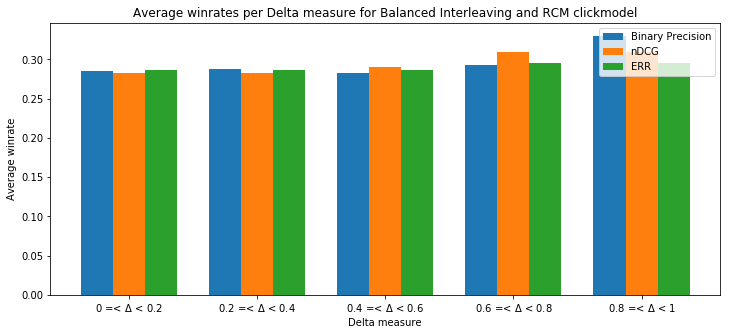

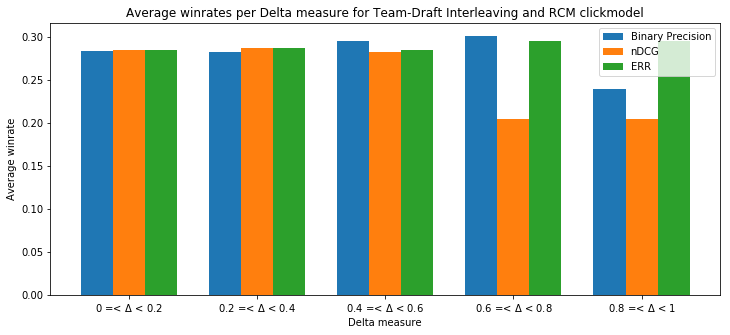

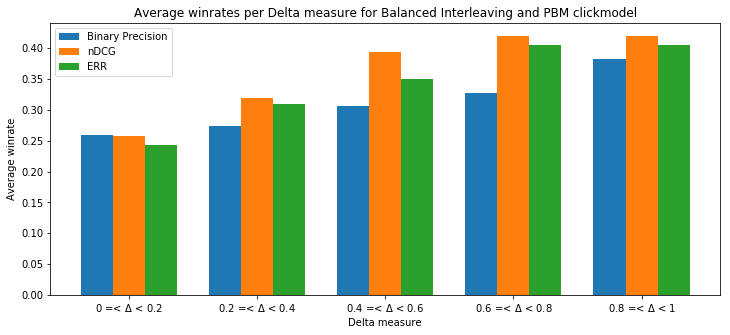

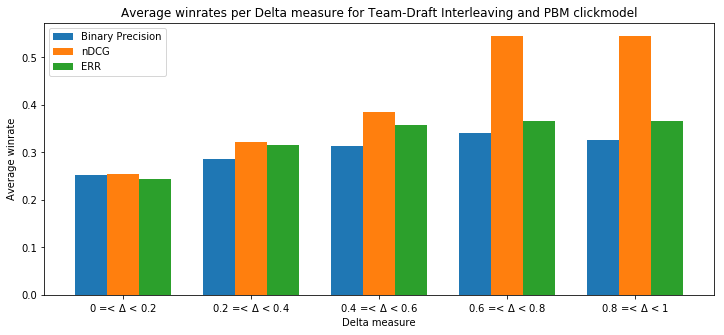

In [239]:
import matplotlib.pyplot as plt


N = 100
offline_measures = {'Binary Precision': data_bp,
                    'nDCG': data_ndcg,
                    'ERR': data_err}
click_models = {'RCM clickmodel': rcm_model,
                'PBM clickmodel': pbm_model}
interleavers = {'Balanced Interleaving': (balanced_interleaving, score_balanced_interleaving),
                'Team-Draft Interleaving': (teamdraft_interleaving, score_teamdraft_interleaving)}

for clickmodel_name, click_model in click_models.items():
    for interleaver_name, (interleaver, scorer) in interleavers.items():
        plt.figure(figsize=(12, 5))
        for measure_idx, (measure_name, data) in enumerate(offline_measures.items()):
            simulation = simulate_interleaving(data, N, click_model, interleaver, scorer)
            win_rates, lose_rates, tie_rates = simulation
            measurements = [d[-1] for d in data]
            binned = np.digitize(measurements, np.linspace(0, 1, 5)[1:])

            avg_winrates = []
            for i in range(5):
                if len(np.argwhere(binned==i)):
                    bin_avg_winrate = np.sum(np.array(win_rates)[np.argwhere(binned==i)]) / len(np.argwhere(binned==i))
                avg_winrates.append(bin_avg_winrate)
            bar_offset = measure_idx * 0.25
            plt.bar(np.arange(5)+bar_offset, avg_winrates, width = 0.25, label=measure_name)
            plt.legend()
            plt.title('Average winrates per Delta measure for {} and {}'.format(interleaver_name, clickmodel_name))
            plt.xlabel('Delta measure')
            plt.xticks(np.arange(5)+0.25, ('0 =< $\Delta$ < 0.2', '0.2 =< $\Delta$ < 0.4', 
                                           '0.4 =< $\Delta$ < 0.6', '0.6 =< $\Delta$ < 0.8', '0.8 =< $\Delta$ < 1'))
            plt.ylabel('Average winrate')
        plt.show()